In [1]:
debug=True

script_option = "Train"
#script_option = "Inference"

#--------------------------------------------------------------------------------------------
#---------------------------------Part 1: Set Ups -------------------------------------------
#--------------------------------------------------------------------------------------------

# read & manipulate data
import pandas as pd
import numpy as np
import tensorflow as tf
import mysql.connector

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib notebook

# misc
import random as rn
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

    
#--------------------------------------------------------------------------------------------
#---------------------------------Part 2: Data and DB connetion -----------------------------
#--------------------------------------------------------------------------------------------


# Initiate with Parameters
db_name = "core_stats"
col = "peak_upload_speed"


# Start Database Connection
db_connection = mysql.connector.connect(
    host="10.1.2.10",
    user="gyan",
    password="5Gaa$2022",
    database="gyan_db"
)


mycursor = db_connection.cursor(dictionary=True)
mycursor.execute("select * from core_stats WHERE client_id='BETBEL01GYN001' AND stats_timestamp > '2022-07-14'")
json_data=mycursor.fetchall() ## The fetchall() is one of Python’s cursor methods used to retrieve all the rows for a certain query.


full_df = pd.DataFrame(json_data)



# Export Anomaly_df is a python Dataframe object.
# MySQL Insert Query includes [tableName], (columns to insert)
# The value stores (col1, col2,col3)
def insert_anomalies_prophet(current_anomlies):
    for index, row in current_anomlies.iterrows():
        connection = mysql.connector.connect(
            host="10.1.2.10",
            user="gyan",
            password="5Gaa$2022",
            database="gyan_db"
        )

        cursor = connection.cursor()

        MySQL_insert_query = "INSERT INTO tb_export_anomaly_df (client_id, stats_timestamp, attribute_name, attribute_value, attribute_label_prophet, attribute_deviation,attribute_mean) VALUES (%s, %s, %s, %s, %s, %s, %s)"

        the_value= (row.client_id, str(row.stats_timestamp), str(row.attribute_label), row.attribute_value, row.attribute_label_prophet, row.attribute_deviation,row.attribute_mean)
        
        try:
            cursor.execute(MySQL_insert_query, the_value)
            connection.commit()
        except:
            print("Record Already Inserted")
            pass

    cursor.close()
    print("Insert Complete")
    

#--------------------------------------------------------------------------------------------
#---------------------------------Part 3: Data Preprocessing --------------------------------
#--------------------------------------------------------------------------------------------

anomaly_points = [
        ["2022-07-14 10:56:00.000000","2022-07-14 16:26:00.000000"],
        ["2022-07-15 13:25:00.000000","2022-07-15 13:47:00.000000"],
        ["2022-08-08 13:52:00.000000","2022-08-08 14:00:00.000000"],
        ["2022-08-09 10:46:00.000000","2022-08-09 10:50:00.000000"],
        ["2022-08-10 12:22:00.000000","2022-08-10 12:38:00.000000"],
        ["2022-09-06 14:32:00.000000","2022-09-06 14:52:00.000000"],
        ["2022-09-06 14:54:00.000000","2022-09-06 15:30:00.000000"],
        ["2022-09-07 09:50:00.000000","2022-09-12 14:20:00.000000"]
        
]

full_df['timestamp'] = pd.to_datetime(full_df['stats_timestamp'])

#is anomaly? : True => 1, False => 0
full_df['label'] = 0
full_df["value"]=full_df["peak_upload_speed"]

for start, end in anomaly_points:
    full_df.loc[((full_df['timestamp'] >= start) & (full_df['timestamp'] <= end) & (full_df["value"]<40000)| (full_df["value"]>50000)), 'label'] = 1
    #full_df.loc[( (full_df["value"]<40000)| (full_df["value"]>50000)), 'label'] = 1

df=full_df.drop(["timestamp","client_id","total_tx_data","total_rx_data" ],axis=1)


# Seperate Train & Test with Timestamp
curr_timestamp= "2022-09-05"
train= df[ df.stats_timestamp< curr_timestamp]
test = df[df.stats_timestamp>= curr_timestamp]

train=train.drop(["stats_timestamp"],axis=1)
test=test.drop(["stats_timestamp"],axis=1)


Training data shape: (26869, 1, 13)
Test data shape: (23386, 1, 13)
Training data shape: (33587, 1, 14)
Test data shape: (23386, 1, 14)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 14)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1984      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                         

<IPython.core.display.Javascript object>


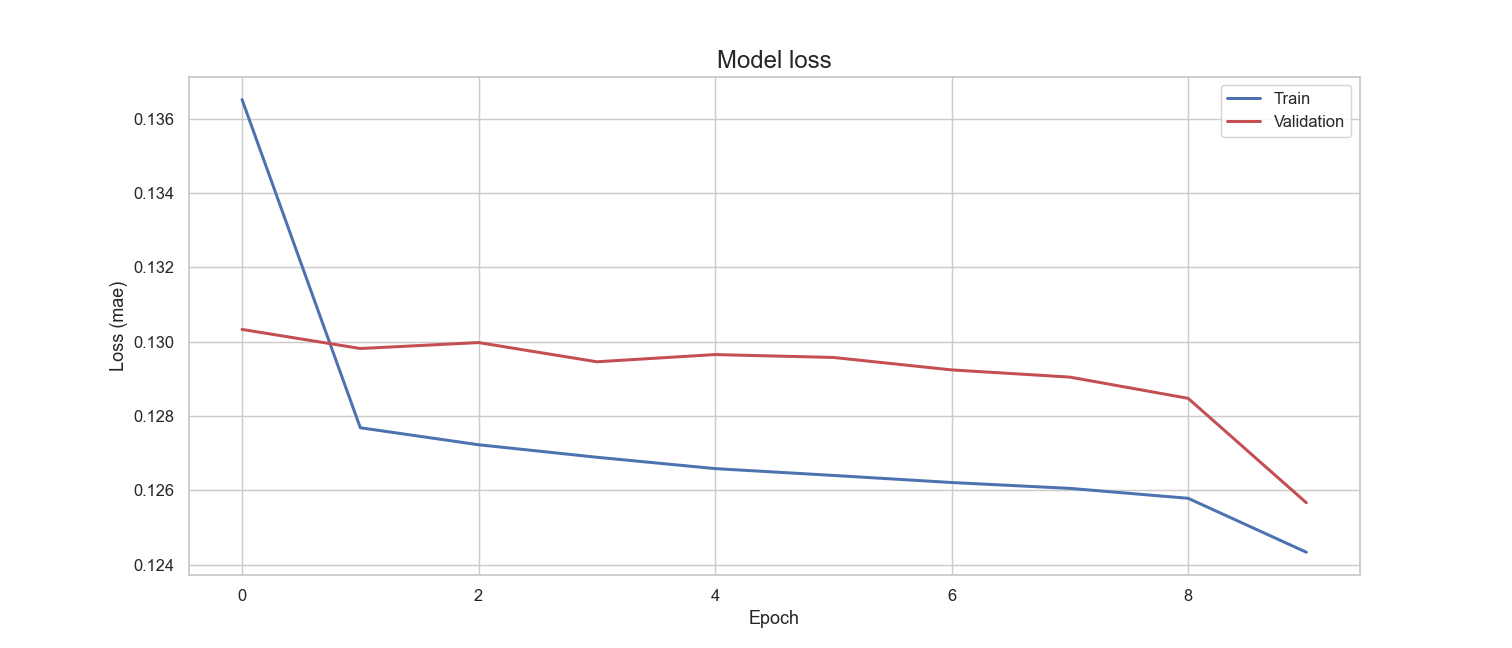

<IPython.core.display.Javascript object>


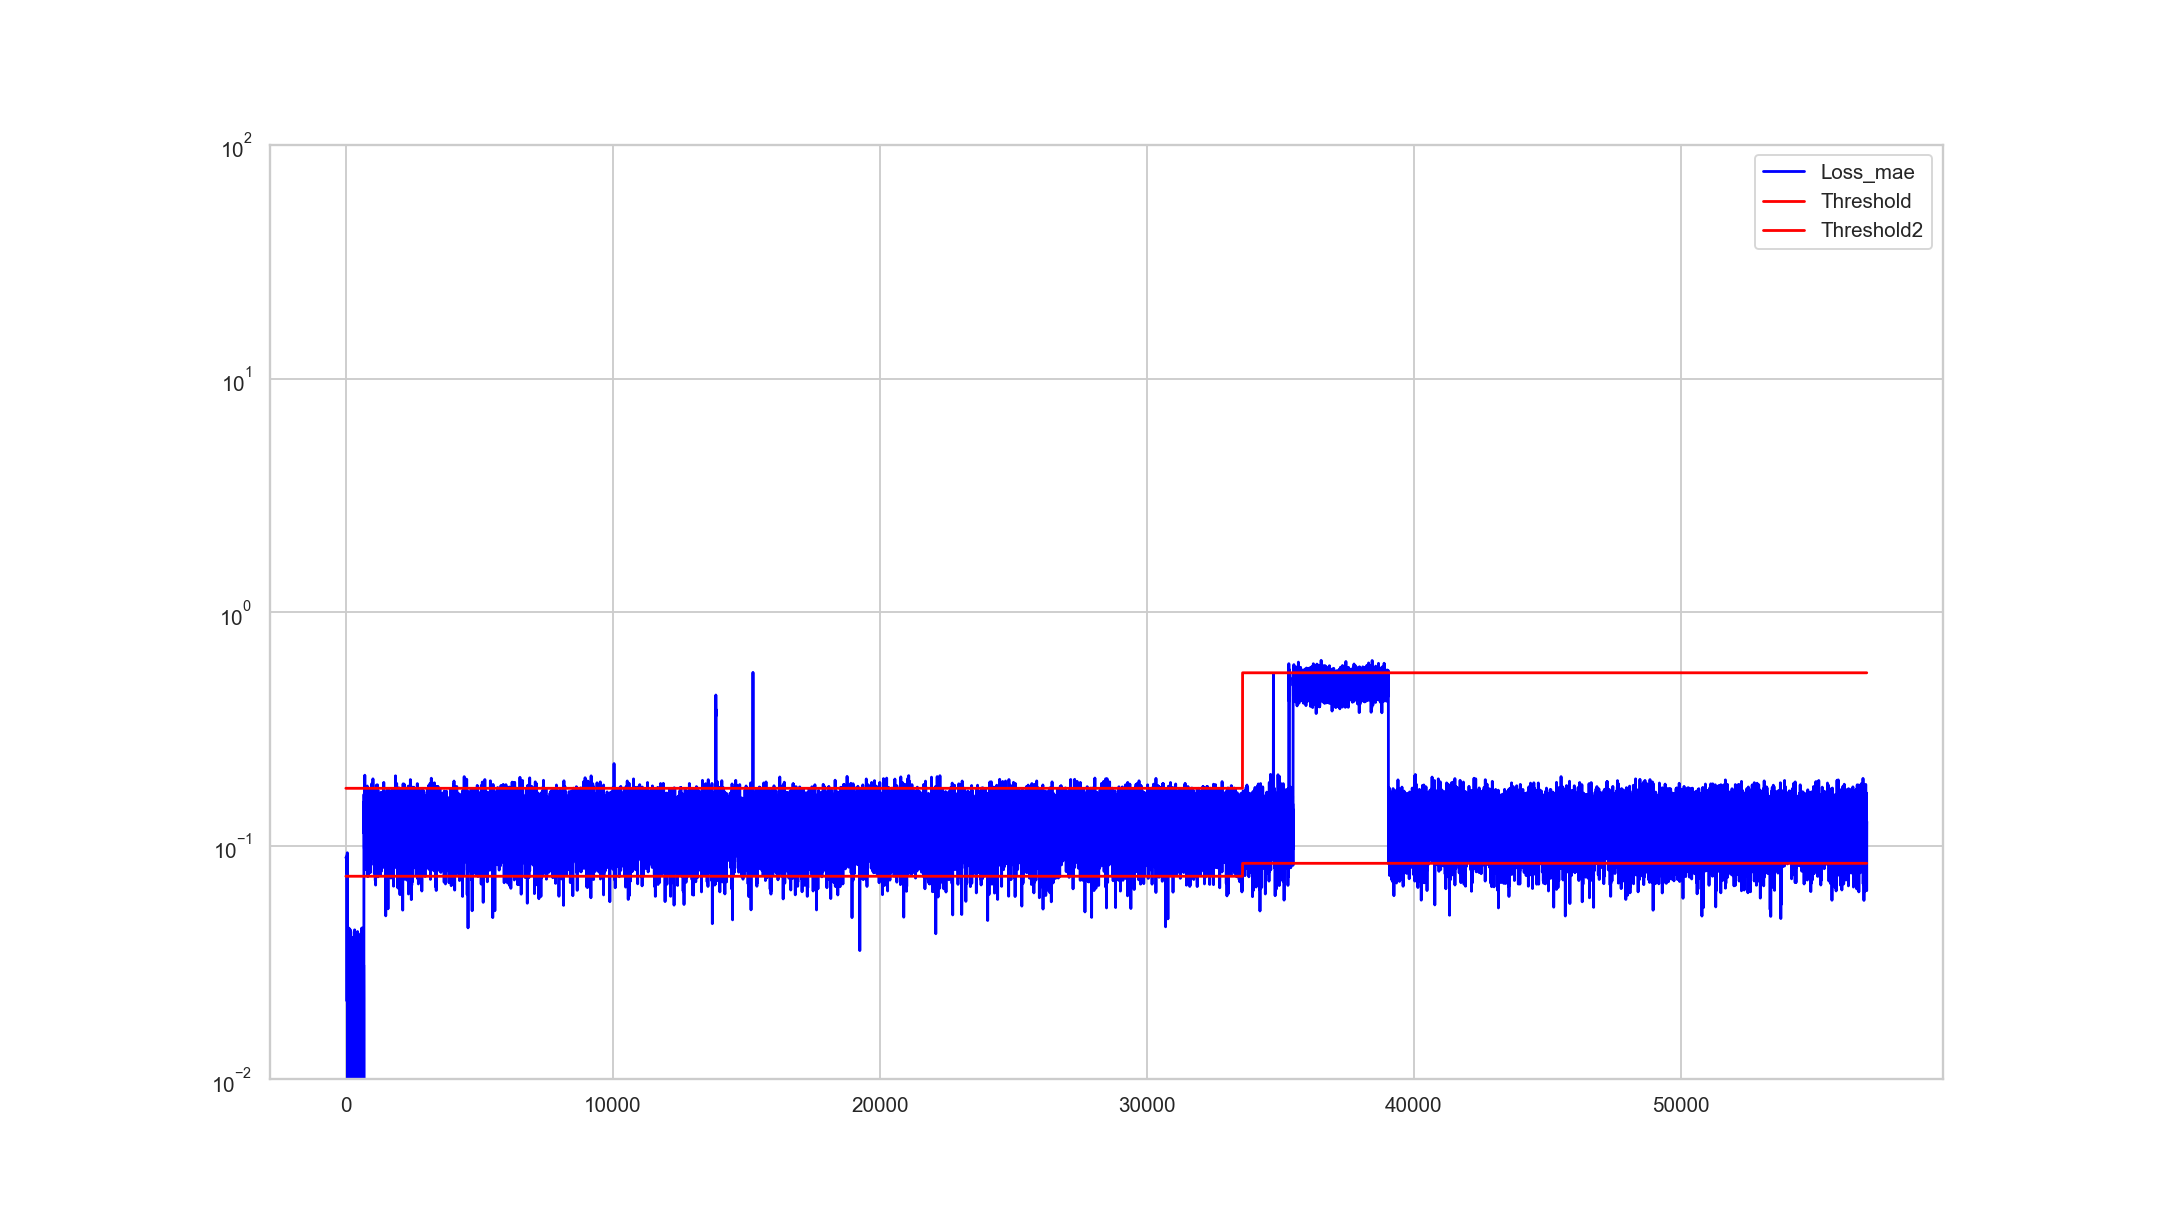

In [2]:
#--------------------------------------------------------------------------------------------
#---------------------------------Part 4: Deep Learning Setup--------------------------------
#--------------------------------------------------------------------------------------------

# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# manual parameters
RANDOM_SEED = 0
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Split train // validate set to Train model 
X_train, X_validate = train_test_split(train, 
                                       test_size=VALIDATE_SIZE, 
                                       random_state=RANDOM_SEED)
# manually splitting the labels from the test df
X_train = X_train.drop('label', axis=1).values
X_validate = X_validate.drop('label', axis=1).values

# manually splitting the labels from the test df
X_validate, y_test = test.drop('label', axis=1).values, test.label.values



# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)



# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])


print("Training data shape:", X_train.shape)
X_validate = X_validate.reshape(X_validate.shape[0], 1, X_validate.shape[1])
print("Test data shape:", X_validate.shape)

# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_validate = scaler.transform(test)

# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_validate = X_validate.reshape(X_validate.shape[0], 1, X_validate.shape[1])
print("Test data shape:", X_validate.shape)




#--------------------------------------------------------------------------------------------
#---------------------------------Part 5: Model Training ------------------------------------
#--------------------------------------------------------------------------------------------

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()


# fit the model to the data
if debug:
    nb_epochs = 10
else:
    nb_epochs= 100

batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history


#--------------------------------------------------------------------------------------------
#---------------------------------Part 6: Evaluation --- ------------------------------------
#--------------------------------------------------------------------------------------------

# plot the loss distribution of the training set
X_pred = model.predict(X_validate)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_validate.reshape(X_validate.shape[0], X_validate.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = np.percentile(scored['Loss_mae'],99) 
scored['Threshold2'] = np.percentile(scored['Loss_mae'],3) 
scored['Anomaly'] = (scored['Loss_mae'] > scored['Threshold']) | (scored['Loss_mae']< scored['Threshold2'])



# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])

scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = np.percentile(scored_train['Loss_mae'],99) 
scored_train['Threshold2'] = np.percentile(scored_train['Loss_mae'],3) 
scored_train['Anomaly'] = (scored_train['Loss_mae'] > scored_train['Threshold']) | (scored_train['Loss_mae']< scored_train['Threshold2'])
scored = pd.concat([scored_train, scored])


#--------------------------------------------------------------------------------------------
#---------------------------------Part 7: Plot ----------------------------------------------
#--------------------------------------------------------------------------------------------
debug=False
if not debug:
    # plot the training losses
    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    ax.plot(history['loss'], 'b', label='Train', linewidth=2)
    ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('Model loss', fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()
    
    # plot bearing failure time plot
    scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red','red'])
